<a href="https://colab.research.google.com/github/Ibraheem101/mlops/blob/main/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import json
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SEED = 1234

In [3]:
np.random.seed(seed = SEED)
random.seed(SEED)

It is common practice to set the seed for both NumPy and the Python built-in random module to ensure consistency across different parts of your code that may use either of these libraries for random number generation.

In [4]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/spiral.csv"
df = pd.read_csv(url, header=0) # load and set first row as column header
df = df.sample(frac=1).reset_index(drop=True) # shuffle to create randomness
df.head()


,X1,X2,color
0,0.106737,0.114197,c1
1,0.311513,-0.664028,c1
2,0.019870,-0.703126,c1
3,-0.054017,0.508159,c3
4,-0.127751,-0.011382,c3


In [5]:
# Data shapes
X = df[["X1", "X2"]].values
y = df["color"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


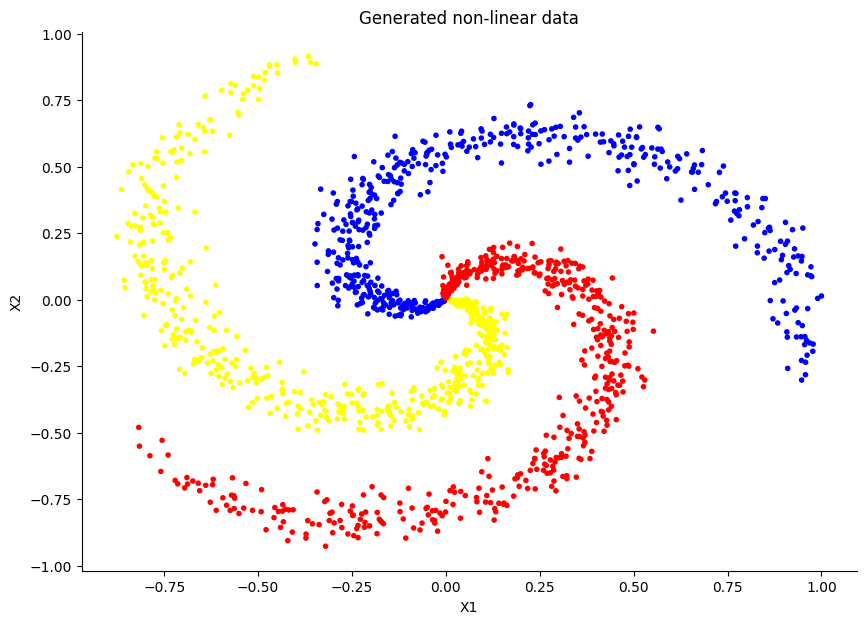

In [6]:
# Visualize data
plt.figure(figsize = (10, 7))
plt.title("Generated non-linear data")
plt.xlabel("X1"), plt.ylabel("X2")
colors = {'c1': 'red', 'c2': 'yellow', 'c3': 'blue'}
plt.scatter(x = X[:, 0], y = X[:, 1], c = [colors[color] for color in y], marker = '.')
sns.despine()

### Split data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [9]:
# Function to split data
def split_train_val_test(X, y, train_size):
  X_train, X_, y_train, y_ = train_test_split(X, y, train_size=0.7, stratify = y)
  X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size = 0.5, stratify = y_)
  return X_train, X_val, X_test, y_train, y_val, y_test

The stratify=y argument ensures that the class distribution is preserved in the train-test split. It means that the proportions of different classes in the original data will be maintained in both the training and testing subsets.

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(X, y, TRAIN_SIZE)

In [11]:
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[1]} → {y_train[1]}")

X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
Sample point: [0.09310622 0.1128395 ] → c1


### Label Encoding

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
label_encoder = LabelEncoder()

In [14]:
label_encoder.fit(y_train)
classes = label_encoder.classes_
print(classes)

y_train_enc = label_encoder.transform(y_train)
y_test_enc = label_encoder.transform(y_test)
y_val_enc = label_encoder.transform(y_val)

['c1' 'c2' 'c3']


In [15]:
# Calculate class weights
class_weights = {}
total_samples = len(y_train_enc)
num_classes = len(np.unique(y_train_enc))
class_samples = np.bincount(y_train_enc)
for i in range(num_classes):
    class_weights[i] = total_samples / (num_classes * class_samples[i])

print(f"Class weights: {class_weights}")

Class weights: {0: 1.0, 1: 1.0, 2: 1.0}


They all have the same weights because the the class samples are equal

In [16]:
class_samples

array([350, 350, 350])

### Standardization

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()

In [19]:
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

### Testing linear models
Motivation for activation functions

In [20]:
torch.manual_seed(seed = SEED) # Set seed

In [21]:
from torch import nn
import torch.nn.functional as F

In [22]:
input_dim = X_train.shape[1]
hidden_dim = 100

In [23]:
input_dim, hidden_dim, num_classes

(2, 100, 3)

In [24]:
# Linear Model
class LinearModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_classes):
    super(LinearModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, num_classes)

  # Define the forward pass
  def forward(self, X_in):
    z = self.fc1(X_in)
    z = self.fc2(z)
    return z

In [25]:
model = LinearModel(input_dim, hidden_dim, num_classes)

In [26]:
print(model.named_parameters)

<bound method Module.named_parameters of LinearModel(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


### Training

In [27]:
lr = 0.01
epochs = 10
batch_size = 32

In [28]:
from torch.optim import Adam

In [29]:
class_weights_t = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_t)

During calculation of the loss, the loss for each sample is weighted according to its corresponding class weight.

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
# Optimizer
optimizer = Adam(model.parameters(), lr=lr)

In [32]:
# Convert data to tensors
X_train_t = torch.Tensor(X_train_scaled)
y_train_t = torch.LongTensor(y_train_enc)
X_val_t = torch.Tensor(X_val_scaled)
y_val_t = torch.LongTensor(y_val_enc)
X_test_t = torch.Tensor(X_test_scaled)
y_test_t = torch.LongTensor(y_test_enc)

In [33]:
for epoch in range(epochs):
  # Forward pass
  y_pred = model(X_train_t)

  # Compute loss
  loss = loss_fn(y_pred, y_train_t)

  # Zero gradients
  optimizer.zero_grad()

  # Backward pass
  loss.backward()

  # Update weights
  optimizer.step()

  if epoch%1==0:
    predictions = y_pred.max(dim=1)[1] # class
    accuracy = accuracy_score(y_pred=predictions, y_true=y_train_t)
    print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.13, accuracy: 0.5
Epoch: 1 | loss: 0.91, accuracy: 0.5
Epoch: 2 | loss: 0.79, accuracy: 0.6
Epoch: 3 | loss: 0.74, accuracy: 0.5
Epoch: 4 | loss: 0.74, accuracy: 0.5
Epoch: 5 | loss: 0.75, accuracy: 0.5
Epoch: 6 | loss: 0.76, accuracy: 0.5
Epoch: 7 | loss: 0.77, accuracy: 0.5
Epoch: 8 | loss: 0.77, accuracy: 0.5
Epoch: 9 | loss: 0.78, accuracy: 0.5


### Evaluation

In [34]:
from sklearn.metrics import precision_recall_fscore_support

In [35]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance


The difference between average="weighted" and average="none" is that the former calculates the weighted average of metrics, taking into account class support, while the latter returns metrics for each individual class separately. 

In [36]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


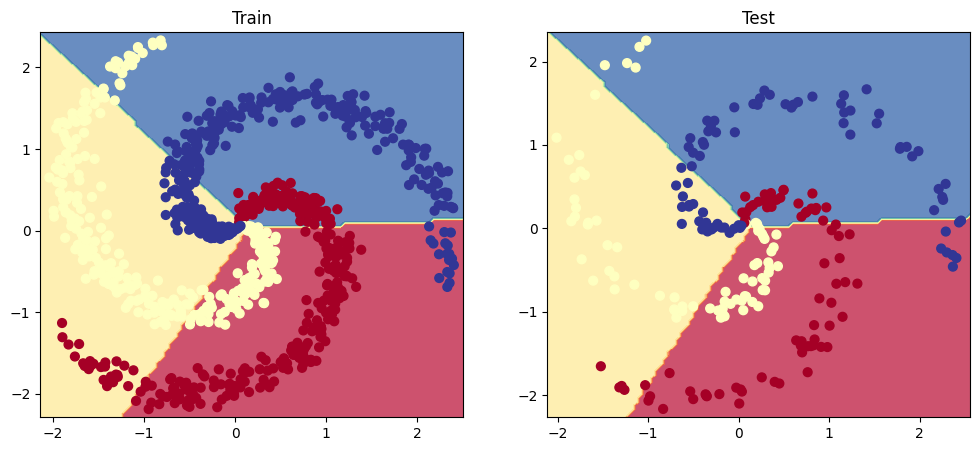

In [37]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train_t, y=y_train_t)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test_t, y=y_test_t)
plt.show()


Not the best performance

### Activation functions
We're going to repeat the steps above but with activation functions to add some non-linearity

## Numpy
Implementing NNs from scratch
$$
\
z_1 = X_1 W_1\\
a_1 = ReLu(z_1)\\
z_2 = a_1 W_2\\
\hat{y} = softmax(a_1)
\
$$


### Weight initialization
W is initialized randomly\
b is initialized to 0

In [38]:
W1 = 0.01 * np.random.randn(input_dim, hidden_dim)
b1 = np.zeros((1, hidden_dim))

print(f"W1 shape: {W1.shape}")
print(f"b1 shape: {b1.shape}")

W1 shape: (2, 100)
b1 shape: (1, 100)


### Model
#### First layer forward pass

In [39]:
z1 = np.dot(X_train_t, W1) + b1
print (f"z1: {z1.shape}")

z1: (1050, 100)


#### Activation function: ReLu

In [40]:
a1 = np.maximum(0, z1) # Element-wise maximum between the two arrays; 0 is auto extended to the lenght of z1.
print (f"a1 shape : {a1.shape}")

a1 shape : (1050, 100)


#### Second layer forward pass

In [41]:
W2 = np.random.randn(hidden_dim, num_classes)
b2 = np.zeros((1, num_classes))

print(f"W2 shape: {W2.shape}")
print(f"b2 shape: {b2.shape}")

W2 shape: (100, 3)
b2 shape: (1, 3)


In [42]:
z2 = np.dot(a1, W2) + b2 # z2 also called logits
print (f"z2: {z2.shape}")

z2: (1050, 3)


$$
\
\hat{y} = softmax(z_2)
$$

In [43]:
# Normalization via softmax to obtain class probabilities
exp_logits = np.exp(z2)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (1050, 3)
sample: [0.28741968 0.44115961 0.27142071]


### Loss
Cross entropy loss
$$
\\
J(\theta) = - \sum_{i} \ln(\hat{y}_i) = - \sum_{i} \ln \left( \frac{e^{X_iW_y}}{\sum_{j} e^{X_iW_j}} \right)
\\
$$

In [44]:
# y_hat[range(len(y_hat)), y_train_t]

In [45]:
# y_hat[range(len(y_hat))]

In [46]:
# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train_t]) # This indexing operation selects the predicted probabilities corresponding to the true labels.
loss = np.sum(correct_class_logprobs) / len(y_train_t)
print (f"loss: {loss:.2f}")

loss: 1.12


### Gradients
With respect to weights W2 and W1\
Check source for equations

In [47]:
# dJ/dW2
dscores = y_hat
dscores[range(len(y_hat)), y_train_t] -= 1
dscores /= len(y_train_t)
dW2 = np.dot(a1.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

In [48]:
# dJ/dW1
dhidden = np.dot(dscores, W2.T)
dhidden[a1 <= 0] = 0 # ReLu backprop
dW1 = np.dot(X_train_t.T, dhidden)
db1 = np.sum(dhidden, axis=0, keepdims=True)

### Update weights
$$
\\
W_i = W_i - \alpha \frac{\partial J}{\partial W_i}
\\
$$

In [49]:
# Update weights
W1 += -lr * dW1
b1 += -lr * db1
W2 += -lr * dW2
b2 += -lr * db2

### Training

In [50]:
# Convert tensors to NumPy arrays
X_train_n = X_train_t.numpy()
y_train_n = y_train_t.numpy()
X_val_n = X_val_t.numpy()
y_val_n = y_val_t.numpy()
X_test_n = X_test_t.numpy()
y_test_n = y_test_t.numpy()

In [51]:
epochs = 1000

In [52]:
# Repeat the entire training process
# Initialize random weights
W1 = 0.01 * np.random.randn(input_dim, hidden_dim)
b1 = np.zeros((1, hidden_dim))
W2 = 0.01 * np.random.randn(hidden_dim, num_classes)
b2 = np.zeros((1, num_classes))

# Training loop
for epoch in range(epochs):

    # First layer forward pass [NX2] · [2X100] = [NX100]
    z1 = np.dot(X_train_n, W1) + b1

    # Apply activation function
    a1 = np.maximum(0, z1) # ReLU

    # z2 = logits = [NX100] · [100X3] = [NX3]
    z2 = np.dot(a1, W2) + b2

    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(z2)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train_n])
    loss = np.sum(correct_class_logprobs) / len(y_train_n)

    # show progress
    if epoch%100 == 0:
        # Accuracy
        y_pred = np.argmax(z2, axis=1)
        accuracy =  np.mean(np.equal(y_train_n, y_pred))
        print (f"Epoch: {epoch}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # dJ/dW2
    dscores = y_hat
    dscores[range(len(y_hat)), y_train_n] -= 1
    dscores /= len(y_train_n)
    dW2 = np.dot(a1.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)

    # dJ/dW1
    dhidden = np.dot(dscores, W2.T)
    dhidden[a1 <= 0] = 0 # ReLu backprop
    dW1 = np.dot(X_train.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)

    # Update weights
    W1 += -1e0 * dW1
    b1 += -1e0 * db1
    W2 += -1e0 * dW2
    b2 += -1e0 * db2


Epoch: 0, loss: 1.099, accuracy: 0.349
Epoch: 100, loss: 0.655, accuracy: 0.587
Epoch: 200, loss: 0.475, accuracy: 0.810
Epoch: 300, loss: 0.276, accuracy: 0.901
Epoch: 400, loss: 0.184, accuracy: 0.933
Epoch: 500, loss: 0.134, accuracy: 0.956
Epoch: 600, loss: 0.103, accuracy: 0.970
Epoch: 700, loss: 0.085, accuracy: 0.979
Epoch: 800, loss: 0.073, accuracy: 0.985
Epoch: 900, loss: 0.064, accuracy: 0.987


### Testing

In [53]:
class MLPFromScratch():
    def predict(self, x):
        z1 = np.dot(x, W1) + b1
        a1 = np.maximum(0, z1)
        z2 = np.dot(a1, W2) + b2
        exp_logits = np.exp(z2)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat

### Evaluation

In [54]:
# Evaluation
model = MLPFromScratch()
y_prob = model.predict(X_test_n)
y_pred = np.argmax(y_prob, axis=1)

In [55]:
# # Performance
performance = get_metrics(y_true=y_test_n, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.9911111111111112,
    "recall": 0.9911111111111112,
    "f1": 0.9911111111111113,
    "num_samples": 225.0
  },
  "class": {
    "c1": {
      "precision": 0.9866666666666667,
      "recall": 0.9866666666666667,
      "f1": 0.9866666666666668,
      "num_samples": 75.0
    },
    "c2": {
      "precision": 0.9866666666666667,
      "recall": 0.9866666666666667,
      "f1": 0.9866666666666668,
      "num_samples": 75.0
    },
    "c3": {
      "precision": 1.0,
      "recall": 1.0,
      "f1": 1.0,
      "num_samples": 75.0
    }
  }
}


Plot decision boundary

In [57]:
def plot_multiclass_decision_boundary_numpy(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format="png")


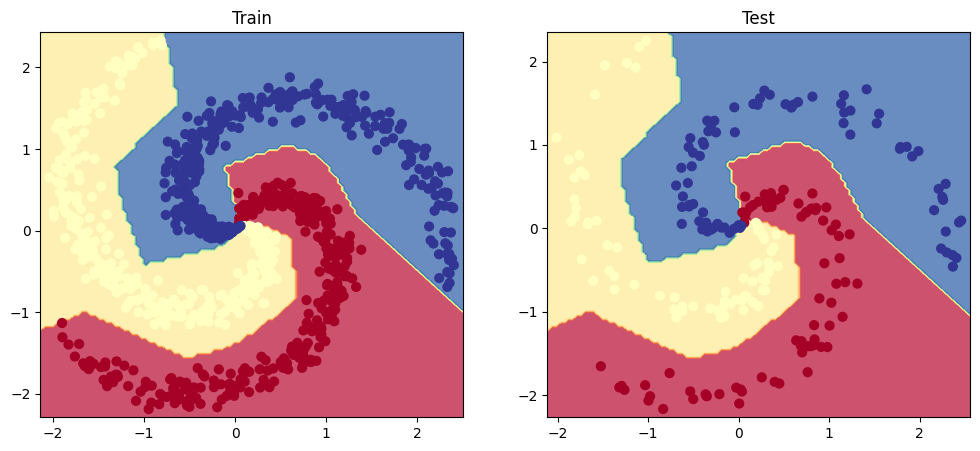

In [58]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary_numpy(model=model, X=X_train_n, y=y_train_n)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary_numpy(model=model, X=X_test_n, y=y_test_n)
plt.show()


Much better